Cryptocurrency trading bot.

Global variable definitions.

In [1]:
traded_asset_symbols = ['OMG', 'BTC', 'USDT']
intervals = ['1h', '1d']
period = '1 month ago UTC'

api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install python-binance --upgrade --no-cache-dir
!pip install plotly stocktrends

Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)
You should consider upgrading via the '/home/samuel/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/samuel/anaconda3/bin/python -m pip install --upgrade pip' command.


Library imports.

In [3]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from stocktrends import Renko
from IPython import display

import math
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Function definitions.

In [4]:
class Cryptocurrency_indicator:
    def __init__(self, name, calculate, OHLC=False):
        self.name = name
        self.calculate = calculate
        self.plot = self._plot_OHLC_ if OHLC else self._plot_default_
        self.value = None

    def update(self, dataset, plot=False):
        self.value = self.calculate(self, dataset.astype(float))

        if plot:
            self.plot()

    def _plot_default_(self):
        print("\n")
        print(self.value)
        plt.plot(self.value)
        plt.show()
        print("\n")

    def _plot_OHLC_(self):
        print("\n")
        print(self.value)
        fig = go.Figure(data=[go.Candlestick(x=self.value.index.to_series(), 
                                             open=self.value['open'], 
                                             high=self.value['high'], 
                                             low=self.value['low'], 
                                             close=self.value['close'])])

        fig.show()
        print("\n")


class Cryptocurrency_indicators_maker:
    def __init__(self, cls, indicators=None):
        if indicators is not None:
            cls.indicators = indicators

        for indicator in dir(cls):
            if indicator.startswith('calculate_'):
                setattr(self, 
                        indicator[10:], 
                        Cryptocurrency_indicator(name=indicator[10:], 
                                                 calculate=getattr(cls, indicator), 
                                                 OHLC=False))

    def update(self, dataset, plot=False):
        for indicator in dir(self):
            attr = getattr(self, indicator)
            if isinstance(attr, Cryptocurrency_indicator):
                attr.update(dataset, plot=plot)


class Cryptocurrency_indicators_base:
    def _calculate_moving_average_(self, dataset, window=2, method='simple'):
        if method == 'simple':
            dataset = dataset.rolling(window=window)
        elif method == 'exponential':
            dataset = dataset.ewm(span=window)

        dataset = dataset.mean()
        dataset = dataset.fillna(method='backfill', axis='index')
        return dataset

    def calculate_simple_moving_average(self, dataset, window=2):
        return Cryptocurrency_indicators_base()._calculate_moving_average_(dataset, window=window, method='simple')

    def calculate_exponential_moving_average(self, dataset, window=2):
        return Cryptocurrency_indicators_base()._calculate_moving_average_(dataset, window=window, method='exponential')

    def calculate_renko(self, dataset, brick_size=1):
        renko_ = dataset[['open', 'high', 'low', 'close']].copy().astype(float)
        renko_.index.name = 'date'
        renko_ = Renko(renko_.reset_index())
        renko_.brick_size = brick_size
        renko_ = renko_.get_ohlc_data().set_index('date')
        renko_.index.name = 'time'
        return renko_.uptrend

    def calculate_heikin_ashi(self, df):
        df = df.tz_localize(tz=None, ambiguous='infer')
        df = df[['open', 'high', 'low', 'close']].copy().astype('float')
        heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
        heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

        for i in range(len(df)):
            if i == 0:
                heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
            else:
                heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

        heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
        heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

        return heikin_ashi_df

    def calculate_RSI(self, ticker, span=14):
        up = ticker['close'].astype(float).pct_change()
        down = up.copy()
        up[up < 0.0] = 0.0
        down[down > 0.0] = 0.0

        up = up.ewm(span=span).mean().fillna(method='pad')
        down = down.ewm(span=span).mean().abs().fillna(method='pad')

        ticker = up / down
        ticker = 100 - (100 / (1 + ticker))

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        return ticker.fillna(method='pad')

    def calculate_MACD(self, ticker, span1=12, span2=26, average='exponential'):
        shorter = Cryptocurrency_indicators_base()._calculate_moving_average_(ticker, window=span1, method=average)['close']
        longer = Cryptocurrency_indicators_base()._calculate_moving_average_(ticker, window=span2, method=average)['close']

        ticker = (shorter - longer).replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        ticker = ticker.fillna(method='pad').to_frame(name='MACD')
        ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
        ticker['histogram'] = ticker.MACD - ticker.signal_line
        return ticker

    def calculate_ATR(self, ticker, min_periods=14):
        ticker = ticker.astype(float)
        up = pd.DataFrame([ticker['high'].shift(), 
                           ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

        down = pd.DataFrame([ticker['low'].shift(), 
                             ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

        ticker = (up - down).ewm(alpha=1 / min_periods, 
                                 min_periods=min_periods, 
                                 adjust=False).mean()

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        return ticker.fillna(method='backfill')

    def calculate_bollinger_bands(self, dataframe, period=20):
        df = dataframe.copy()
        df['MA'] = Cryptocurrency_indicators_base()._calculate_moving_average_(df, window=period, method='simple')['close']
        df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
        df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
        df['BB_width'] = df['BB_up'] - df['BB_down']
        return df[['BB_up', 'BB_down', 'BB_width']].dropna()

    def calculate_average_directional_index(self, df, n=14, n_ADX=14):
        dataset_index = df.index.copy()
        df = df.reset_index().drop(columns=['time']).astype(float)
        i = 0
        UpI = []
        DoI = []

        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']

            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0

            UpI.append(UpD)

            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0

            DoI.append(DoD)
            i += 1

        ATR = Cryptocurrency_indicators_base().calculate_ATR(df, min_periods=14)
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR, name='PosDI')
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR, name='NegDI')
        ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, 
                                                                   min_periods=n_ADX).mean(), 
                        name='ADX')

        df = df.join(ADX).join(PosDI).join(NegDI)
        df.index = dataset_index
        return df[['ADX', 'PosDI', 'NegDI']].dropna()

    def calculate_commodity_channel_index(self, dataset, min_periods=20):
        PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
        CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                        PP.rolling(min_periods, min_periods=min_periods).std(),
                        name='CCI')
        return dataset.join(CCI)['CCI']

    def calculate_KDJ(self, dataset):
        def get_rsv(dataset):
            low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
            high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
            return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

        def calc_kd(column):
            k = 50.0
            for i in (1.0 / 3.0) * column:
                k = (2.0 / 3.0) * k + i
                yield k

        dataset['K'] = list(calc_kd(get_rsv(dataset)))
        dataset['D'] = list(calc_kd(dataset['K']))
        dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
        return dataset[['K', 'D', 'J']]

    def calculate_relative_volume_level(self, 
                                        dataset, 
                                        average_1=26, 
                                        average_2=14, 
                                        threshold=1.75, 
                                        method='exponential'):

        volume = dataset[['volume']]
        volume_average = Cryptocurrency_indicators_base()._calculate_moving_average_(volume, window=average_1, method=method)
        relative_volume = volume / average_1
        smoothed_relative_volume = Cryptocurrency_indicators_base()._calculate_moving_average_(relative_volume, window=average_2, method=method)
        relative_volume_level = smoothed_relative_volume.iloc[-1] / smoothed_relative_volume.iloc[-2]
        return relative_volume_level > threshold


class Cryptocurrency_triggers_base(Cryptocurrency_indicators_base):
    def __init__(self):
        super().__init__()

    def calculate_trend_trigger(self, dataset):
        heikin_ashi = Cryptocurrency_indicators_base().calculate_simple_moving_average(dataset, window=1)
        heikin_ashi = Cryptocurrency_indicators_base().calculate_heikin_ashi(heikin_ashi)
        heikin_ashi = Cryptocurrency_indicators_base().calculate_exponential_moving_average(dataset, window=1)
        return (heikin_ashi['close'] - heikin_ashi['open']) > 0

    def calculate_overtraded_trigger(self, dataset):
        RSI_6 = Cryptocurrency_indicators_base().calculate_RSI(dataset, span=6)
        RSI_12 = Cryptocurrency_indicators_base().calculate_RSI(dataset, span=12)
        return RSI_6 > RSI_12

    def calculate_trend_strength_trigger(self, dataset):
        ADX = Cryptocurrency_indicators_base().calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['ADX'] > 0.25

    def calculate_trend_strength_positive_trigger(self, dataset):
        ADX = Cryptocurrency_indicators_base().calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] > ADX['NegDI']

    def calculate_trend_strength_negative_trigger(self, dataset):
        ADX = Cryptocurrency_indicators_base().calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] < ADX['NegDI']

    def calculate_momentum_trigger(self, dataset):
        KDJ = Cryptocurrency_indicators_base().calculate_KDJ(dataset)
        return KDJ['J'] > KDJ['D']

    def calculate_volatility_trigger(self, dataset):
        bollinger_bands = Cryptocurrency_indicators_base().calculate_bollinger_bands(dataset, period=20)
        return (bollinger_bands['BB_width'] / dataset['close']) > 0.0005

    def calculate_MACD_trigger(self, dataset):
        MACD = Cryptocurrency_indicators_base().calculate_MACD(dataset)
        return MACD['histogram'] > 0

    def calculate_real_trigger(self, dataset):
        return (dataset['close'] - dataset['open']) > 0


class Cryptocurrency_pair_info:
    def __init__(self, client, pair):
        self.client = client
        self.pair = pair

        pair_info = client.get_symbol_info(self.pair)
        self.base_asset = pair_info['baseAsset']
        self.quote_asset = pair_info['quoteAsset']
        self.precision = pair_info['quotePrecision']

        filters = pair_info['filters']
        price_filter = [ticker for ticker in filters if ticker['filterType'] == 'PRICE_FILTER']
        lot_size = [ticker for ticker in filters if ticker['filterType'] == 'LOT_SIZE']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in price_filter][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in lot_size][0]

        self.calculate_balance()

    def calculate_balance(self):
        self.base_asset_balance = float(self.client.get_asset_balance(asset=self.base_asset)['free'])
        self.quote_asset_balance = float(self.client.get_asset_balance(asset=self.quote_asset)['free'])
        self.pair_last_price = float(self.client.get_ticker(symbol=self.pair)['lastPrice'])
        self.pair_buy_balance = self.quote_asset_balance / self.pair_last_price
        self.pair_sell_balance = self.base_asset_balance * self.pair_last_price
        self.pair_combined_base_balance = self.pair_buy_balance + self.base_asset_balance
        self.pair_combined_quote_balance = self.pair_sell_balance + self.quote_asset_balance

    def print_balance(self):
        print('base_asset_balance: ', self.base_asset_balance)
        print('quote_asset_balance: ', self.quote_asset_balance)
        print('pair_last_price: ', self.pair_last_price)
        print('pair_buy_balance: ', self.pair_buy_balance)
        print('pair_sell_balance: ', self.pair_sell_balance)
        print('pair_combined_base_balance: ', self.pair_combined_base_balance)
        print('pair_combined_quote_balance: ', self.pair_combined_quote_balance)


class Cryptocurrency_pair_at_interval:
    def __init__(self, client, info, interval, period=period, download=True, initial_plot=True):
        self.dataset = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])

        if download:
            self.dataset = self.download_dataset(client=client, 
                                                 symbol=info['pair'], 
                                                 interval=interval, 
                                                 period=period)

        self.indicators = Cryptocurrency_indicators_maker(Cryptocurrency_indicators_base)
        self.triggers = Cryptocurrency_indicators_maker(Cryptocurrency_triggers_base, self.indicators)
        self.update(plot=initial_plot)

    def update(self, plot=False):
        self.indicators.update(self.dataset, plot=plot)
        self.triggers.update(self.dataset, plot=plot)

    def download_dataset(self, client, symbol, interval, period):
        if interval == 'price':
            return pd.DataFrame(client.get_recent_trades(symbol=symbol))
        else:
            dataset_downloaded = \
                client.get_historical_klines(symbol=symbol, 
                                             interval=interval, 
                                             start_str=period)

            dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                              columns=['time', 
                                                       'open', 
                                                       'high', 
                                                       'low', 
                                                       'close', 
                                                       'volume', 
                                                       'Close time', 
                                                       'Quote asset volume', 
                                                       'Number of trades', 
                                                       'Taker buy base asset volume', 
                                                       'Taker buy quote asset volume', 
                                                       'Ignore'])

            four_hours = 14400
            milliseconds = 1000

            dataset_downloaded['time'] = \
                dataset_downloaded['time'].apply(lambda timestamp: \
                                                 datetime.datetime.fromtimestamp((timestamp / \
                                                                                  milliseconds) - \
                                                                                 four_hours))

            dataset_downloaded = dataset_downloaded[['time', 
                                                     'open', 
                                                     'high', 
                                                     'low', 
                                                     'close', 
                                                     'volume']]

            dataset_downloaded.set_index('time', inplace=True)
            dataset_downloaded = dataset_downloaded.applymap(lambda entry: entry.rstrip('0').rstrip('.'))
            return dataset_downloaded


class Cryptocurrency_trader:
    def __init__(self, percentage_to_trade=0.999999):
        self.percentage_to_trade = percentage_to_trade
        self.state = 'entry'
        self.tradable = True

    def calculate_position(self):
        if self.info.base_asset_buy_balance > self.info.base_asset_sell_balance:
            self.position = 'sell'
        elif self.info.base_asset_sell_balance > self.info.base_asset_buy_balance:
            self.position = 'buy'

    def trade(self):
        self.info.calculate_balance()

        if self.position == 'sell':
            coins_available = self.info.pair_buy_balance
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = self.info.pair_sell_balance
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= self.percentage_to_trade
        quantity = math.floor(coins_available * 10**self.info.step_size) / float(10**self.info.step_size)

        if self.info.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.info.tick_size)) / float(abs(self.info.tick_size))

        client.create_order(symbol=self.pair_symbol, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.info.calculate_balance()
        self.info.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.info.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.info.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position


class Cryptocurrency_pair(Cryptocurrency_trader):
    def __init__(self, 
                 client, 
                 pair, 
                 intervals=intervals, 
                 period=period, 
                 percentage_to_trade=0.999999, 
                 raw_price=True, 
                 download=True, 
                 initial_plot=True):

        self.period = period
        self.raw_price = raw_price
        self.download = download

        super().__init__(percentage_to_trade=percentage_to_trade)
        self.info = self.get_pair_info(client, pair)
        self.interval = self.get_datasets(client, intervals, initial_plot=initial_plot)

    def get_pair_info(self, client, pair):
        return Cryptocurrency_pair_info(client=client, pair=pair).__dict__

    def get_datasets(self, client, intervals, initial_plot=True):
        dataset = dict()

        if self.raw_price:
            dataset['price'] = Cryptocurrency_pair_at_interval(client=client, 
                                                               info=self.info, 
                                                               interval='price', 
                                                               period=self.period, 
                                                               download=self.download, 
                                                               initial_plot=initial_plot)

        for interval in intervals:
            dataset[interval] = Cryptocurrency_pair_at_interval(client=client, 
                                                                info=self.info, 
                                                                interval=interval, 
                                                                period=self.period, 
                                                                download=self.download, 
                                                                initial_plot=initial_plot)

        return dataset

    def make_OHLC_dataset(self, dataset, interval=intervals[0]):
        dataset = dataset.resample(interval)
        volume = dataset.agg({'quantity': ['sum']})['quantity']
        dataset = dataset.agg({'price': ['first', 'max', 'min', 'last']})['price']
        dataset['volume'] = volume
        dataset = dataset.dropna(axis='index')
        dataset = dataset.rename(columns={'first': 'open', 
                                          'max': 'high', 
                                          'min': 'low', 
                                          'last': 'close', 
                                          'sum': 'volume'})

        return dataset


class Cryptocurrency_bot:
    def __init__(self, 
                 client, 
                 traded_asset_symbols=traded_asset_symbols, 
                 intervals=intervals, 
                 period=period, 
                 percentage_to_trade=0.999999, 
                 raw_price=True, 
                 initial_plot=True):

        self.all_symbols = self.get_all_symbols(client)
        traded_pair_symbols = self.get_traded_pairs_from_assets(traded_asset_symbols)

        self.pairs = self.get_pairs(client, 
                                    intervals, 
                                    period, 
                                    percentage_to_trade, 
                                    raw_price, 
                                    traded_pair_symbols, 
                                    initial_plot=initial_plot)

        self.traded_asset_symbol = self.get_richest_asset(traded_asset_symbols, traded_pair_symbols)

    def get_all_symbols(self, client):
        return [symbol['symbol'] for symbol in client.get_all_tickers()]

    def get_traded_pairs_from_assets(self, traded_asset_symbols):
        traded_pair_symbols = []
        for base_asset in traded_asset_symbols:
            for quote_asset in traded_asset_symbols:
                if base_asset != quote_asset:
                    for pair in [base_asset + quote_asset, quote_asset + base_asset]:
                        if pair in self.all_symbols:
                            traded_pair_symbols.append(pair)

        return traded_pair_symbols

    def get_pairs(self, 
                  client, 
                  intervals, 
                  period, 
                  percentage_to_trade, 
                  raw_price, 
                  traded_pair_symbols, 
                  initial_plot=True):

        pairs = dict()
        for pair in traded_pair_symbols:
            pairs[pair] = Cryptocurrency_pair(client=client, 
                                              pair=pair, 
                                              intervals=intervals, 
                                              period=period, 
                                              percentage_to_trade=percentage_to_trade, 
                                              raw_price=raw_price, 
                                              download=True, 
                                              initial_plot=initial_plot)

        return pairs

    def get_richest_asset(self, traded_asset_symbols, traded_pair_symbols):
        richest_count = dict()
        for traded_asset_symbol in traded_asset_symbols:
            richest_count.update({traded_asset_symbol: 0})

        for traded_pair_symbol in traded_pair_symbols:
            base_asset = self.pairs[traded_pair_symbol].info['base_asset']
            quote_asset = self.pairs[traded_pair_symbol].info['quote_asset']
            if self.pairs[traded_pair_symbol].info['base_asset_balance'] >= \
                    self.pairs[traded_pair_symbol].info['quote_asset_balance']:
                richest_count.update({base_asset: richest_count[base_asset] + 1})
            elif self.pairs[traded_pair_symbol].info['base_asset_balance'] < \
                    self.pairs[traded_pair_symbol].info['quote_asset_balance']:
                richest_count.update({quote_asset: richest_count[quote_asset] + 1})

        return max(richest_count, key=richest_count.get)



time
2020-05-10 07:00:00    8.920376e-07
2020-05-10 08:00:00    8.920376e-07
2020-05-10 09:00:00    8.920376e-07
2020-05-10 10:00:00    8.920376e-07
2020-05-10 11:00:00    8.920376e-07
                           ...     
2020-06-10 02:00:00    1.570345e-06
2020-06-10 03:00:00    1.522463e-06
2020-06-10 04:00:00    1.492287e-06
2020-06-10 05:00:00    1.471410e-06
2020-06-10 06:00:00    1.509166e-06
Length: 744, dtype: float64


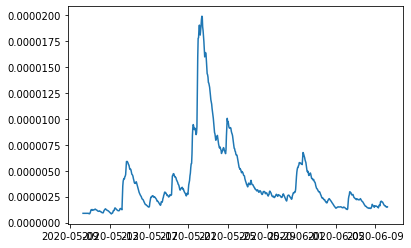





                             K          D          J
time                                                
2020-05-10 07:00:00  40.740741  46.913580  28.395062
2020-05-10 08:00:00  52.650690  48.825950  60.300169
2020-05-10 09:00:00  40.982813  46.211571  30.525297
2020-05-10 10:00:00  41.047365  44.490169  34.161758
2020-05-10 11:00:00  54.815891  47.932076  68.583519
...                        ...        ...        ...
2020-06-10 02:00:00  51.431687  69.137482  16.020096
2020-06-10 03:00:00  42.621124  60.298696   7.265981
2020-06-10 04:00:00  46.747416  55.781603  28.679043
2020-06-10 05:00:00  49.498278  53.687161  41.120510
2020-06-10 06:00:00  37.039256  48.137859  14.842049

[744 rows x 3 columns]


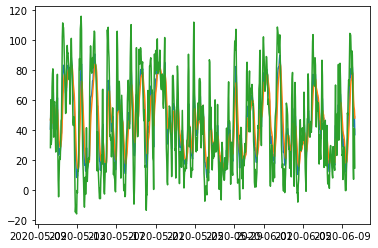





                             MACD   signal_line     histogram
time                                                         
2020-05-10 07:00:00  2.243590e-08  2.243590e-08  0.000000e+00
2020-05-10 08:00:00  2.243590e-08  2.243590e-08  0.000000e+00
2020-05-10 09:00:00 -2.422154e-09  1.224817e-08 -1.467033e-08
2020-05-10 10:00:00  7.731260e-10  8.360961e-09 -7.587835e-09
2020-05-10 11:00:00  3.034773e-08  1.490153e-08  1.544620e-08
...                           ...           ...           ...
2020-06-10 02:00:00 -6.267642e-07 -7.828805e-07  1.561164e-07
2020-06-10 03:00:00 -6.285105e-07 -7.520065e-07  1.234960e-07
2020-06-10 04:00:00 -5.748530e-07 -7.165758e-07  1.417228e-07
2020-06-10 05:00:00 -5.262626e-07 -6.785132e-07  1.522506e-07
2020-06-10 06:00:00 -6.417400e-07 -6.711585e-07  2.941852e-08

[744 rows x 3 columns]


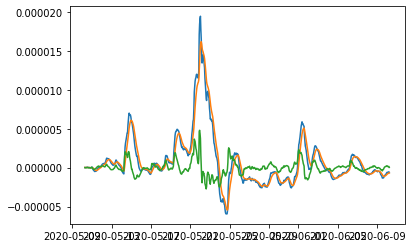





time
2020-05-10 07:00:00    100.000000
2020-05-10 08:00:00    100.000000
2020-05-10 09:00:00     46.749240
2020-05-10 10:00:00     57.363934
2020-05-10 11:00:00     69.554892
                          ...    
2020-06-10 02:00:00     39.917768
2020-06-10 03:00:00     42.642992
2020-06-10 04:00:00     50.418512
2020-06-10 05:00:00     50.418512
2020-06-10 06:00:00     31.521815
Name: close, Length: 744, dtype: float64


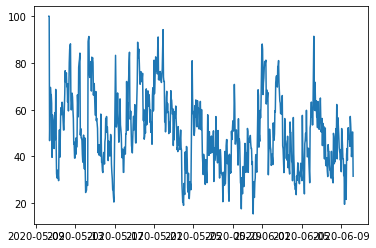





                          ADX     PosDI     NegDI
time                                             
2020-05-11 09:00:00  0.286957  0.166337  0.258372
2020-05-11 10:00:00  0.286057  0.144926  0.258204
2020-05-11 11:00:00  0.250909  0.200349  0.221062
2020-05-11 12:00:00  0.226956  0.219353  0.184228
2020-05-11 13:00:00  0.206763  0.188609  0.158407
...                       ...       ...       ...
2020-06-10 01:00:00  0.410334  0.077409  0.217178
2020-06-10 02:00:00  0.425277  0.066662  0.212498
2020-06-10 03:00:00  0.413241  0.094621  0.189957
2020-06-10 04:00:00  0.402810  0.083664  0.167958
2020-06-10 05:00:00  0.432580  0.073537  0.319800

[717 rows x 3 columns]


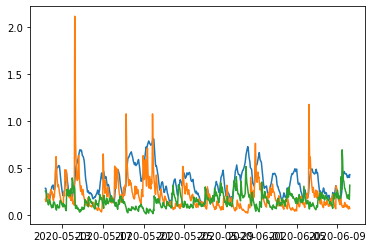





                        BB_up   BB_down      BB_width
time                                                 
2020-05-11 02:00:00  0.000078  0.000078  0.000000e+00
2020-05-11 03:00:00  0.000078  0.000078  3.801316e-08
2020-05-11 04:00:00  0.000077  0.000077  1.035921e-07
2020-05-11 05:00:00  0.000077  0.000077  1.619942e-07
2020-05-11 06:00:00  0.000077  0.000077  2.306284e-07
...                       ...       ...           ...
2020-06-10 02:00:00  0.000170  0.000168  2.214899e-06
2020-06-10 03:00:00  0.000170  0.000168  2.140309e-06
2020-06-10 04:00:00  0.000170  0.000168  2.037902e-06
2020-06-10 05:00:00  0.000170  0.000168  1.912247e-06
2020-06-10 06:00:00  0.000170  0.000168  1.789253e-06

[725 rows x 3 columns]


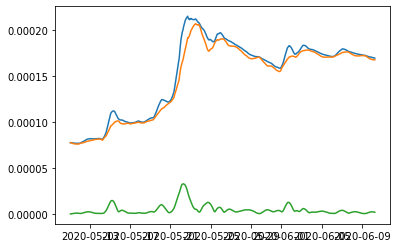





time
2020-05-10 07:00:00         NaN
2020-05-10 08:00:00         NaN
2020-05-10 09:00:00         NaN
2020-05-10 10:00:00         NaN
2020-05-10 11:00:00         NaN
                         ...   
2020-06-10 02:00:00   -0.314837
2020-06-10 03:00:00   -0.366308
2020-06-10 04:00:00    0.161359
2020-06-10 05:00:00    0.282599
2020-06-10 06:00:00   -1.141006
Name: CCI, Length: 744, dtype: float64


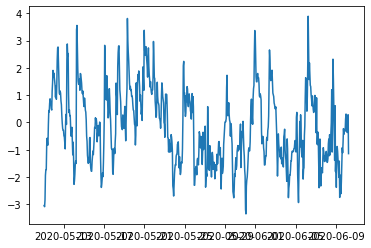





                         open      high       low     close        volume
time                                                                     
2020-05-10 07:00:00  0.000077  0.000078  0.000077  0.000077  24986.870000
2020-05-10 08:00:00  0.000077  0.000078  0.000077  0.000078  67471.407500
2020-05-10 09:00:00  0.000078  0.000078  0.000077  0.000077  36288.292308
2020-05-10 10:00:00  0.000078  0.000078  0.000077  0.000077  16297.774250
2020-05-10 11:00:00  0.000078  0.000078  0.000077  0.000078  10226.687521
...                       ...       ...       ...       ...           ...
2020-06-10 02:00:00  0.000169  0.000170  0.000169  0.000169   8482.057104
2020-06-10 03:00:00  0.000169  0.000169  0.000168  0.000169  18436.299035
2020-06-10 04:00:00  0.000169  0.000169  0.000168  0.000169  19066.293012
2020-06-10 05:00:00  0.000169  0.000169  0.000169  0.000169  14227.991004
2020-06-10 06:00:00  0.000169  0.000169  0.000167  0.000168  31336.650335

[744 rows x 5 columns]


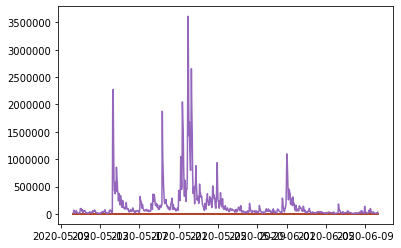





                            open      high       low     close
2020-05-10 07:00:00     7.74e-05  0.000078  0.000077  0.000077
2020-05-10 08:00:00    7.735e-05  0.000078  0.000077  0.000078
2020-05-10 09:00:00     7.75e-05  0.000078  0.000077  0.000078
2020-05-10 10:00:00  7.75125e-05  0.000078  0.000077  0.000077
2020-05-10 11:00:00  7.74937e-05  0.000078  0.000077  0.000078
...                          ...       ...       ...       ...
2020-06-10 02:00:00  0.000169523  0.000170  0.000168  0.000169
2020-06-10 03:00:00  0.000169161  0.000169  0.000168  0.000169
2020-06-10 04:00:00  0.000168843  0.000169  0.000168  0.000169
2020-06-10 05:00:00  0.000168834  0.000169  0.000169  0.000169
2020-06-10 06:00:00  0.000168955  0.000169  0.000167  0.000168

[744 rows x 4 columns]


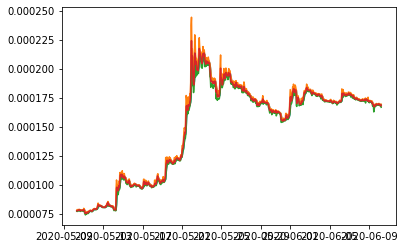





volume    False
dtype: bool


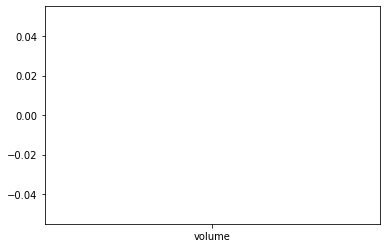





time
2020-05-10 07:00:00    True
Name: uptrend, dtype: bool


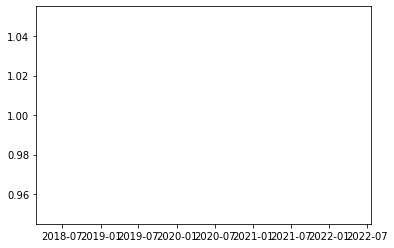





                         open      high       low     close     volume
time                                                                  
2020-05-10 07:00:00  0.000077  0.000078  0.000077  0.000078  53309.895
2020-05-10 08:00:00  0.000077  0.000078  0.000077  0.000078  53309.895
2020-05-10 09:00:00  0.000078  0.000078  0.000077  0.000078  52031.025
2020-05-10 10:00:00  0.000078  0.000078  0.000077  0.000077  14550.920
2020-05-10 11:00:00  0.000078  0.000078  0.000077  0.000078   6950.665
...                       ...       ...       ...       ...        ...
2020-06-10 02:00:00  0.000169  0.000170  0.000169  0.000169   8211.495
2020-06-10 03:00:00  0.000169  0.000169  0.000168  0.000169  16057.565
2020-06-10 04:00:00  0.000168  0.000169  0.000168  0.000169  21397.355
2020-06-10 05:00:00  0.000169  0.000169  0.000168  0.000169  15595.065
2020-06-10 06:00:00  0.000169  0.000169  0.000168  0.000168  25849.910

[744 rows x 5 columns]


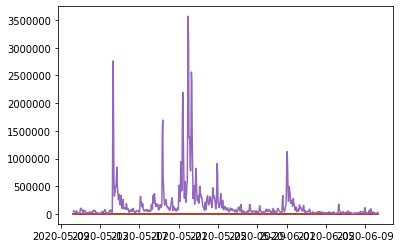





time
2020-05-10 07:00:00    8.920376e-07
2020-05-10 08:00:00    8.920376e-07
2020-05-10 09:00:00    8.920376e-07
2020-05-10 10:00:00    8.920376e-07
2020-05-10 11:00:00    8.920376e-07
                           ...     
2020-06-10 02:00:00    1.570345e-06
2020-06-10 03:00:00    1.522463e-06
2020-06-10 04:00:00    1.492287e-06
2020-06-10 05:00:00    1.471410e-06
2020-06-10 06:00:00    1.509166e-06
Length: 744, dtype: float64


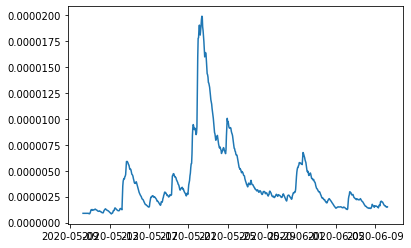





                             K          D          J
time                                                
2020-05-10 07:00:00  40.740741  46.913580  28.395062
2020-05-10 08:00:00  52.650690  48.825950  60.300169
2020-05-10 09:00:00  40.982813  46.211571  30.525297
2020-05-10 10:00:00  41.047365  44.490169  34.161758
2020-05-10 11:00:00  54.815891  47.932076  68.583519
...                        ...        ...        ...
2020-06-10 02:00:00  51.431687  69.137482  16.020096
2020-06-10 03:00:00  42.621124  60.298696   7.265981
2020-06-10 04:00:00  46.747416  55.781603  28.679043
2020-06-10 05:00:00  49.498278  53.687161  41.120510
2020-06-10 06:00:00  37.039256  48.137859  14.842049

[744 rows x 3 columns]


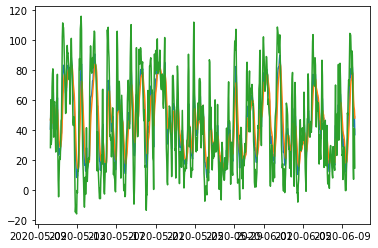





                             MACD   signal_line     histogram
time                                                         
2020-05-10 07:00:00  2.243590e-08  2.243590e-08  0.000000e+00
2020-05-10 08:00:00  2.243590e-08  2.243590e-08  0.000000e+00
2020-05-10 09:00:00 -2.422154e-09  1.224817e-08 -1.467033e-08
2020-05-10 10:00:00  7.731260e-10  8.360961e-09 -7.587835e-09
2020-05-10 11:00:00  3.034773e-08  1.490153e-08  1.544620e-08
...                           ...           ...           ...
2020-06-10 02:00:00 -6.267642e-07 -7.828805e-07  1.561164e-07
2020-06-10 03:00:00 -6.285105e-07 -7.520065e-07  1.234960e-07
2020-06-10 04:00:00 -5.748530e-07 -7.165758e-07  1.417228e-07
2020-06-10 05:00:00 -5.262626e-07 -6.785132e-07  1.522506e-07
2020-06-10 06:00:00 -6.417400e-07 -6.711585e-07  2.941852e-08

[744 rows x 3 columns]


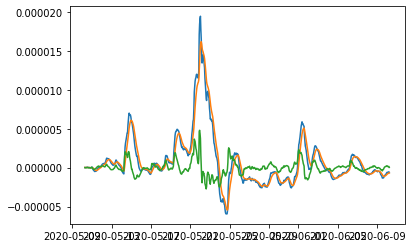





time
2020-05-10 07:00:00    False
2020-05-10 08:00:00    False
2020-05-10 09:00:00    False
2020-05-10 10:00:00    False
2020-05-10 11:00:00     True
                       ...  
2020-06-10 02:00:00     True
2020-06-10 03:00:00     True
2020-06-10 04:00:00     True
2020-06-10 05:00:00     True
2020-06-10 06:00:00     True
Name: histogram, Length: 744, dtype: bool


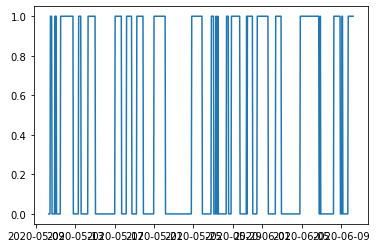





time
2020-05-10 07:00:00    100.000000
2020-05-10 08:00:00    100.000000
2020-05-10 09:00:00     46.749240
2020-05-10 10:00:00     57.363934
2020-05-10 11:00:00     69.554892
                          ...    
2020-06-10 02:00:00     39.917768
2020-06-10 03:00:00     42.642992
2020-06-10 04:00:00     50.418512
2020-06-10 05:00:00     50.418512
2020-06-10 06:00:00     31.521815
Name: close, Length: 744, dtype: float64


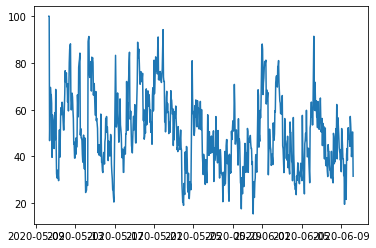





                          ADX     PosDI     NegDI
time                                             
2020-05-11 09:00:00  0.286957  0.166337  0.258372
2020-05-11 10:00:00  0.286057  0.144926  0.258204
2020-05-11 11:00:00  0.250909  0.200349  0.221062
2020-05-11 12:00:00  0.226956  0.219353  0.184228
2020-05-11 13:00:00  0.206763  0.188609  0.158407
...                       ...       ...       ...
2020-06-10 01:00:00  0.410334  0.077409  0.217178
2020-06-10 02:00:00  0.425277  0.066662  0.212498
2020-06-10 03:00:00  0.413241  0.094621  0.189957
2020-06-10 04:00:00  0.402810  0.083664  0.167958
2020-06-10 05:00:00  0.432580  0.073537  0.319800

[717 rows x 3 columns]


In [ ]:
client = Client(api_key, api_secret)

crypto_bot = Cryptocurrency_bot(client=client, 
                                traded_asset_symbols=traded_asset_symbols, 
                                intervals=intervals, 
                                period=period, 
                                percentage_to_trade=0.999999, 
                                raw_price=False, 
                                initial_plot=True)

crypto_bot.__dict__.keys()

In [ ]:
# --- Development separation --- #

In [ ]:
'''
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()
'''

datasets = dict()
for symbol in symbols.keys():
    datasets.update({symbol: {'price': None, 
                              '15s': pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume']), 
                              '1m': pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])}})

def process_message(msg):
    global datasets, traded_symbol, intervals
    four_hours = 14400
    millisecond = 1000

    msg = msg['data']
    symbol = msg['s']
    dataset = datasets[symbol]
    price = dataset['price']
    quote_asset_precision = symbols[symbol].quote_asset_precision

    last_data = \
        pd.DataFrame([["{:0.0{}f}".format(float(msg['a']), quote_asset_precision).rstrip('0').rstrip('.'), 
                       "{:0.0{}f}".format(float(msg['p']), quote_asset_precision).rstrip('0').rstrip('.'), 
                       "{:0.0{}f}".format(float(msg['q']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                     index=[datetime.datetime.fromtimestamp(int(msg['E'] / millisecond) - four_hours)], 
                     columns=['id', 'price', 'quantity'])

    last_data.index.name = 'time'

    if price is None:
        dataset.update({'price': last_data})
    elif price['id'].iloc[-1] > last_data['id'].iloc[-1]:
        price = price.append(last_data).iloc[-1000:]

    for interval in intervals:
        dataset[interval] = make_OHLC_dataset(price, interval=interval)

    dataset['price'] = price
    datasets[symbol] = dataset
    datasets[symbol].calculate_indicators()

    if symbol == traded_symbol:
        if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@trade' for symbol in symbols.keys()], 
                                     process_message)
bm.start()

'''
scores = {}
for crypto_pair in symbols.values():
    scores.update({crypto_pair.base_asset: 0})
    scores.update({crypto_pair.quote_asset: 0})

while True:
    time.sleep(15)
    for symbol in symbols.keys():
        symbols[symbol].calculate_balance()
        symbols[symbol].calculate_position()

    scores = {}
    for crypto_pair in symbols.values():
        scores.update({crypto_pair.base_asset: 0})
        scores.update({crypto_pair.quote_asset: 0})

    for asset in scores.keys():
        for symbol in symbols.keys():
            if symbols[symbol].base_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] + 1})
                else:
                    scores.update({asset: scores[asset] - 1})
            elif symbols[symbol].quote_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] - 1})
                else:
                    scores.update({asset: scores[asset] + 1})

    assets = scores.keys()
    best_assets = [asset for asset in scores.keys() if scores[asset] > 0]
    print('best_assets: ', best_assets)

    if best_assets != [] and \
            not (symbols[traded_symbol].base_asset in best_assets or \
            symbols[traded_symbol].quote_asset in best_assets):

        if symbols[traded_symbol].position == 'buy':
            asset = symbols[traded_symbol].base_asset
        elif symbols[traded_symbol].position == 'sell':
            asset = symbols[traded_symbol].quote_asset

        target_symbols = [symbol for symbol in symbols.keys() \
                          if asset in symbol and any([asset in symbol for asset in best_assets])]

        target_symbol = target_symbols[0]
        symbols[target_symbol].state = 'exit'

        if symbols[target_symbol].base_asset == asset:
            symbols[target_symbol].position = 'buy'
        elif symbols[target_symbol].quote_asset == asset:
            symbols[target_symbol].position = 'sell'

        traded_symbol = target_symbol
'''

In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()